In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()
    
paths = [f.path for f in os.scandir('target/criterion/') if f.is_dir()]
paths.remove('target/criterion/report')

report = {}

for path in paths:
    path_end = path.split('/')[-1].split(' ')
    function_name = path_end[0]
        
    size_paths = [f.path for f in os.scandir(path) if f.is_dir() and not f.path.endswith('report')]
        
    for size_path in size_paths:
        size = int(size_path.split('/')[-1])
        with open(os.path.join(size_path, 'base', 'estimates.json'), 'r') as f:
            data = json.load(f)
            
            if function_name not in report:
                report[function_name] = {}
                            
            report[function_name][size] = data['median']['point_estimate']
        

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df = pd.DataFrame(report)
df

,cost_filter,cost_nft_transfer,cost_create_var,cost_analysis_iterable_func,cost_fold,cost_analysis_check_let,cost_analysis_type_lookup,cost_secp256k1recover,cost_contract_storage,cost_index_of,cost_user_function_application,cost_ft_balance,cost_trait_checker,cost_create_ft,cost_analysis_get_function_entry,cost_nft_owner,cost_nft_mint,cost_fetch_var,cost_nft_burn,cost_unwrap_err,cost_stx_balance,cost_le,cost_type_parse_step,cost_contract_of,cost_inner_type_check_cost,cost_eq,cost_hash160,cost_some_cons,cost_as_max_len,cost_analysis_type_check,cost_analysis_lookup_variable_const,cost_if,cost_ft_get_supply,cost_analysis_check_tuple_merge,cost_is_okay,cost_leq,cost_unwrap_err_or_ret,cost_mul,cost_analysis_type_annotate,cost_analysis_tuple_items_check,cost_keccak256,cost_int_cast,cost_at_block,cost_analysis_use_trait_entry,cost_fetch_entry,cost_tuple_cons,cost_asserts,cost_div,cost_default_to,cost_not,cost_lookup_function,cost_analysis_check_tuple_get,cost_create_nft,cost_principal_of,cost_contract_call,poison_microblock,cost_pow,cost_sha256,cost_unwrap_ret,cost_ast_parse,cost_analysis_check_tuple_cons,cost_load_contract,cost_xor,cost_tuple_merge,cost_mod,cost_analysis_lookup_function_types,cost_analysis_lookup_variable_depth,cost_append,cost_geq,cost_is_err,cost_print,cost_analysis_list_items_check,cost_try_ret,cost_lookup_variable_size,cost_sha512t256,cost_analysis_option_cons,cost_set_var,cost_analysis_bind_name,cost_log2,cost_analysis_visit,cost_or,cost_match,cost_ft_transfer,cost_begin,cost_secp256k1verify,cost_type_checker,cost_read_only,cost_analysis_lookup_function,cost_concat,cost_ft_mint,cost_err_cons,cost_set_entry,cost_len,cost_ast_cycle_detection,cost_ft_burn,cost_analysis_storage,cost_ge,cost_lookup_variable_depth,cost_is_some,cost_sqrti,cost_list_cons,cost_analysis_option_check,cost_let,cost_ok_cons,cost_sha512,cost_map,cost_bind_name,cost_block_info,cost_unwrap,cost_and,cost_add,cost_is_none,cost_stx_transfer,cost_arithmetic_only_checker,cost_tuple_get,cost_element_at,cost_create_map,cost_sub
1,262314.471318,472582.143694,1.288923e+06,7.811398e+04,293626.955483,8.353366e+04,6996.707242,8.587299e+06,4.814168e+06,318751.82815,1.346953e+04,326372.326425,NaN,NaN,NaN,408507.230769,434405.710623,407643.14418,386610.705582,164039.179398,832029.041667,NaN,3158.432503,8035149.75,13505.285999,9.073894e+04,167232.995507,130665.630718,289389.702858,4.309374e+03,9052.22045,114912.149949,284945.440894,1.649938e+05,165011.602447,NaN,191895.931938,98050.240527,10565.166307,4.446445e+04,155494.626246,94748.983248,123304.057435,NaN,879994.232143,1.342955e+05,90959.085594,98479.919697,153447.501839,95342.052763,NaN,311.938470,9.336439e+05,NaN,92543.012738,17624793.0,NaN,142792.134831,198481.620301,168988260.5,3.671111e+04,NaN,NaN,2.366128e+05,NaN,NaN,17775.330483,614853.980263,NaN,161363.488732,930851.733528,1.842603e+04,165580.898889,7028.946333,145660.573177,30660.137142,433802.930957,8.766207e+04,93669.276353,10220.837827,91211.327601,189616.613929,337811.803571,113844.051708,8.093139e+06,NaN,NaN,NaN,602995.086538,974493.983146,123366.381818,944665.367115,266606.837554,1.002795e+05,359478.673069,NaN,NaN,10916.483067,130234.131452,99060.61446,1.044178e+05,78639.885027,162117.27602,125543.23112,142245.989952,2.147217e+06,164351.591459,3.532191e+06,168959.693182,89458.071023,97175.403636,137628.926668,866616.957961,NaN,7.267998e+04,328878.217006,NaN,98305.722970
32,NaN,NaN,1.781217e+06,2.670979e+06,NaN,8.685365e+05,27056.001078,NaN,5.141520e+06,NaN,4.653639e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53554.237318,2.610423e+05,NaN,NaN,NaN,2.875468e+05,NaN,NaN,NaN,3.124560e+06,NaN,NaN,NaN,NaN,71428.036502,2.642292e+05,NaN,NaN,NaN,NaN,NaN,1.254720e+06,NaN,NaN,NaN,NaN,NaN,4616.500912,1.055226e+06,NaN,NaN,NaN,NaN,NaN,NaN,173728424.5,1.326219e+06,NaN,NaN,3.720870e+06,NaN,NaN,121333.551946,NaN,NaN,NaN,NaN,4.497417e+05,NaN,45034.286623,NaN,NaN,NaN,3.502758e+05,NaN,NaN,153167.730252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2

In [3]:
def estimate_params(df, name, transform):
    X = df.index.values.reshape(-1, 1)
    Y = df[name].values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))].reshape(-1, 1)
    Y = Y[np.logical_not(np.isnan(Y))]
    X = transform(X)
#     Y = transform(Y)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    
    b = linear_regressor.intercept_
    if b < 0:
        b = max(Y[0] - linear_regressor.coef_, 0)
    a = linear_regressor.coef_
    
    return (a, b)
    
def logn(n):
    return np.log2(n)

def nlogn(n):
    return n * np.log2(n)

def plot(df, name, a, b, transform):
    Y = df[name].values.reshape(-1, 1)
    X = df.index.values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))]
    X = transform(X)
    Y = Y[np.logical_not(np.isnan(Y))]
    
    y_pred = a*X + b
    
    plt.scatter(X, Y, color='orange')
    plt.suptitle(name)
    plt.plot(X, y_pred, color='blue')
    plt.show()

def estimate_plot(df, fun_name, output, transform = lambda x: x):
    a, b = estimate_params(df, fun_name, transform)
    print(a, b)
#     output.loc[fun_name] = [a.squeeze(), b.squeeze()]
    if not isinstance(a, int):
        a = a.squeeze()
    if not isinstance(b, int):
        b = b.squeeze()
    output.loc[fun_name] = [a, b]
    plot(df, fun_name, a, b, transform)

[2196.40741185] 7239.343508296006


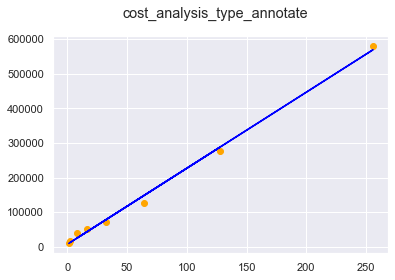

[67348.89498075] 0


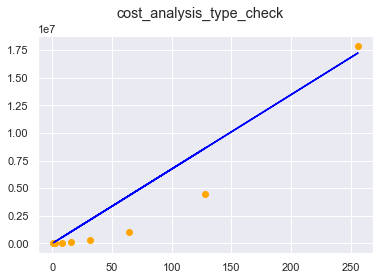

[919.74791028] 3593.9920039861827


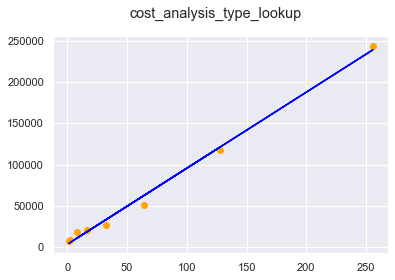

[0.] 10220.837826797386


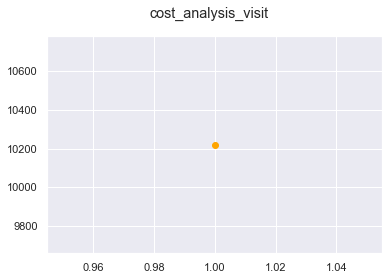

[158002.68692334] 0


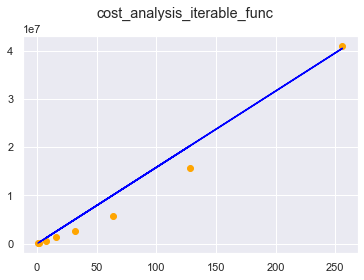

[0.] 30660.137141656443


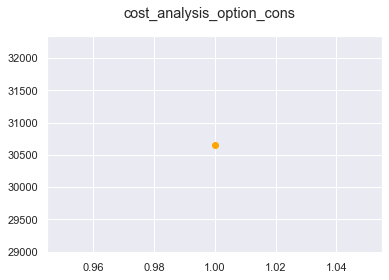

[0.] 78639.88502733878


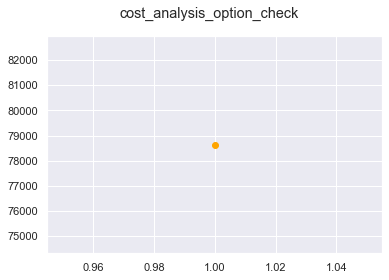

[8924.60771227] 86854.44443093648


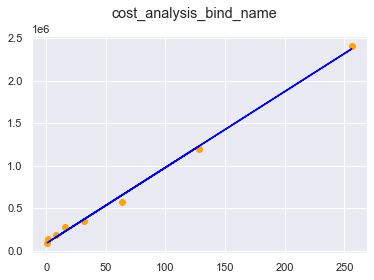

[15329.07303467] [3096.95617379]


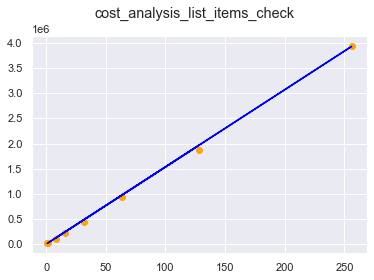

[18.19094381] 1181.4576622514314


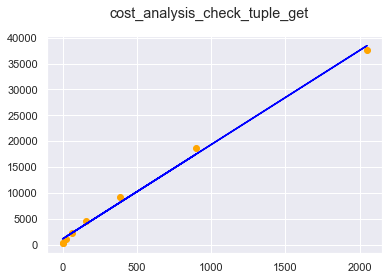

[7386.25499845] 38964.290827539284


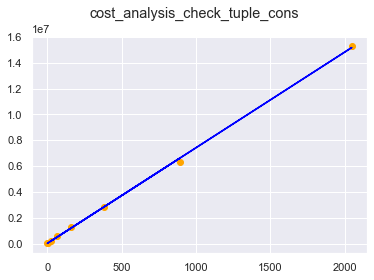

[8227.03461287] 30511.995470589376


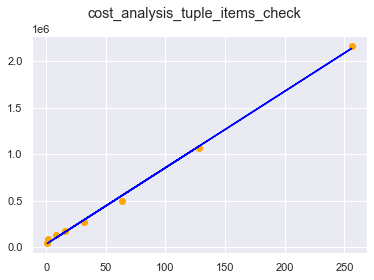

[31102.58204935] [52431.07836731]


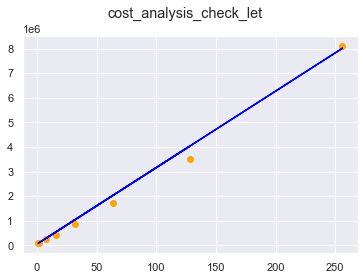

[0.] 13012.90952422819


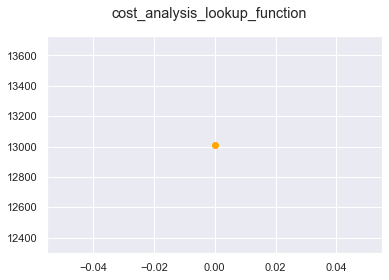

[998.24216455] 16591.03091500356


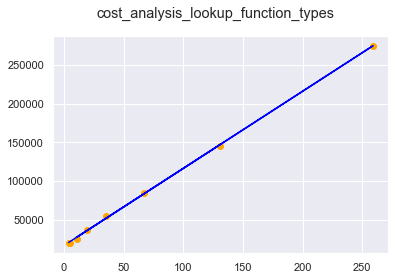

[0.] 9052.220450435641


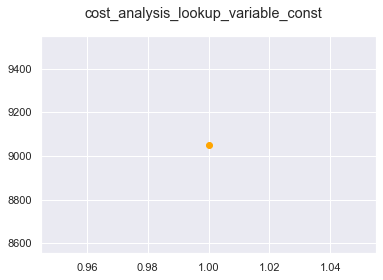

[423.73812823] 39142.58658449049


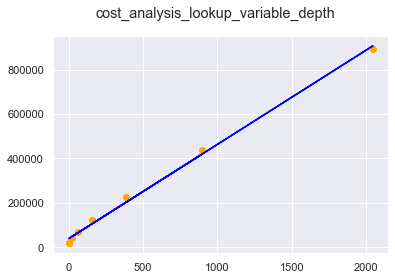

[176.83983828] 3275.990909657965


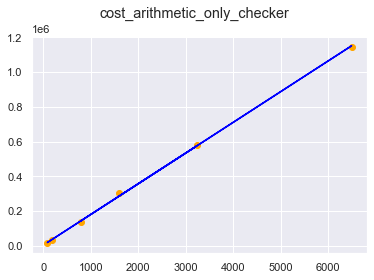

[532.49344128] [3003589.38891166]


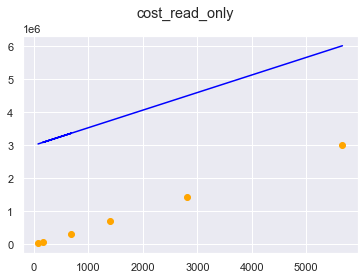

[51149.12761559] [678271.39807885]


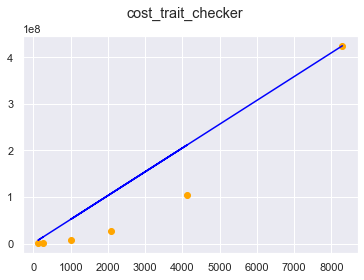

[36568.52434755] [1147838.22065245]


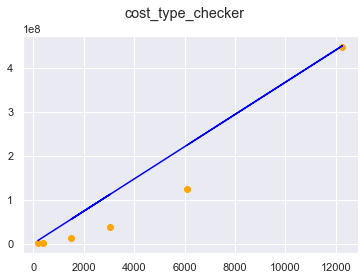

[102887.29638854] 169754275.65387636


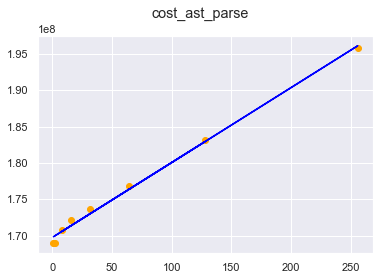

[84611.08497514] [15668.43614684]


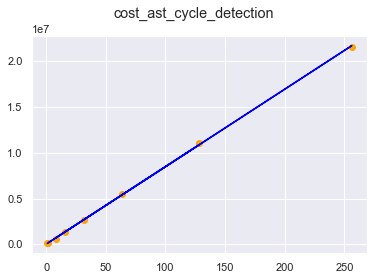

[102.86274261] [3039.69269083]


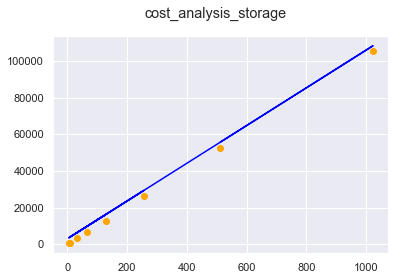

[5959.32331289] 442169.2246189273


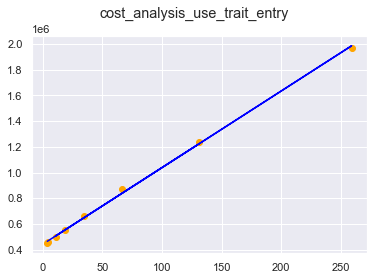

[49501.31280939] 807261.2774978802


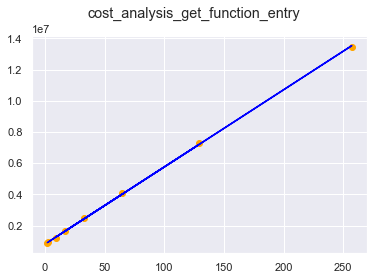

[1681.01498185] 8592.381425724001


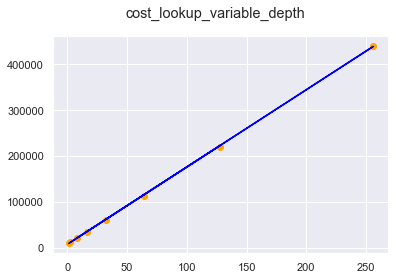

[1399.38894798] 944.045390557556


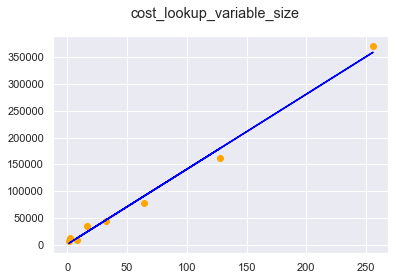

[0.] 15644.151210039512


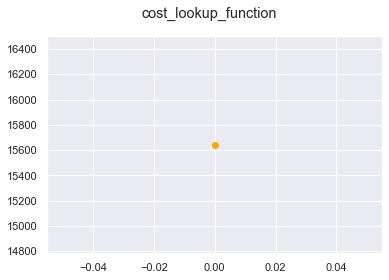

[0.] 164351.59145880575


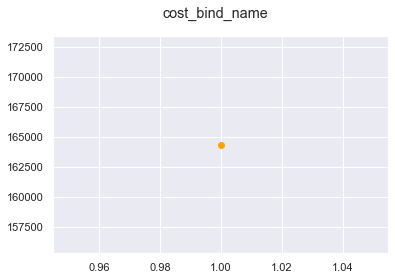

[1590.36269643] 5534.35918464094


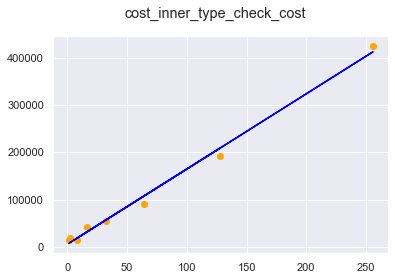

[15989.80805146] 0


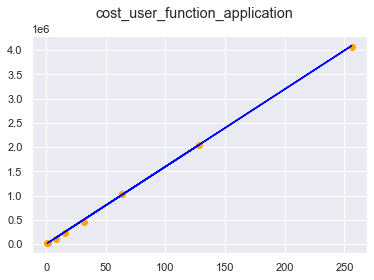

[0.] 162117.27602040814


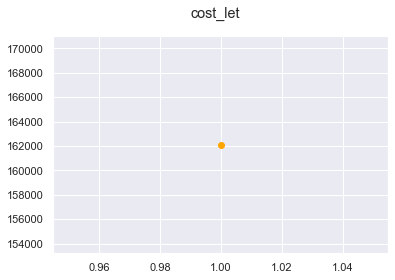

[0.] 114912.14994934143


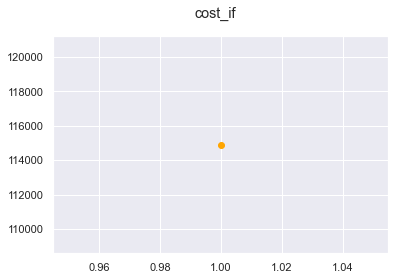

[0.] 90959.08559420033


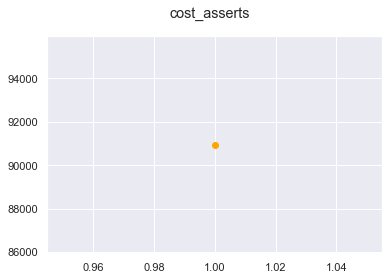

[711682.44230164] 1995510.3317783326


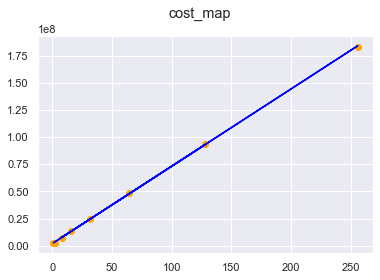

[0.] 262314.47131849313


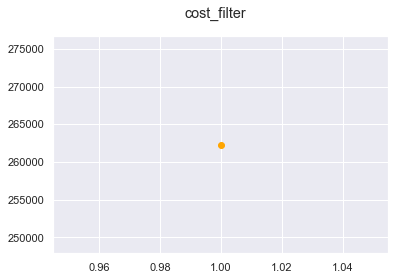

[0.] 266606.83755370125


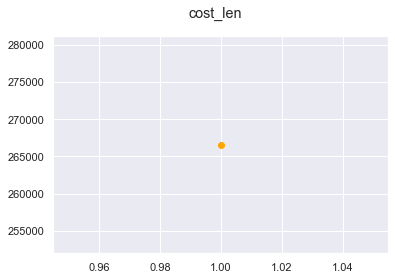

[0.] 328878.2170055822


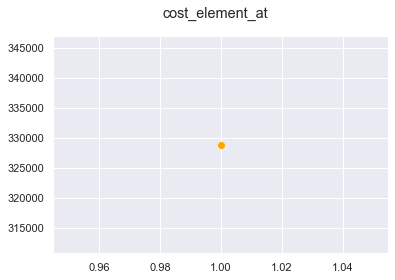

[0.] 318751.8281504065


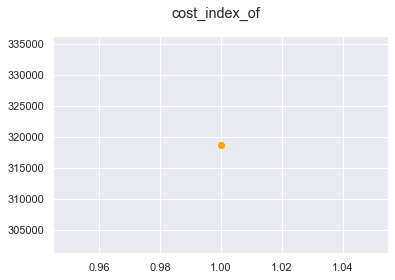

[0.] 293626.9554834906


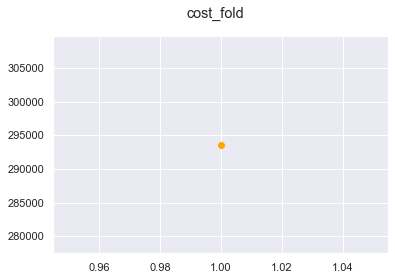

[8819.94065529] 115244.07886917994


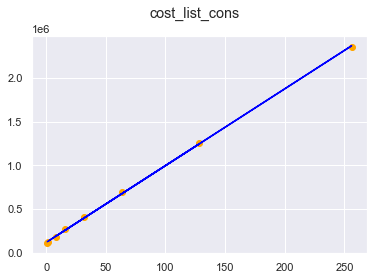

[0.] 3158.4325032552083


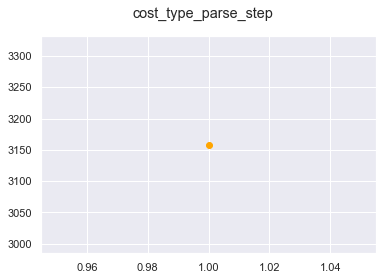

[2573.70747723] 1068296.0694764256


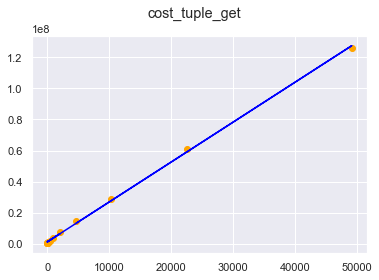

[125171.50344048] [111441.30727381]


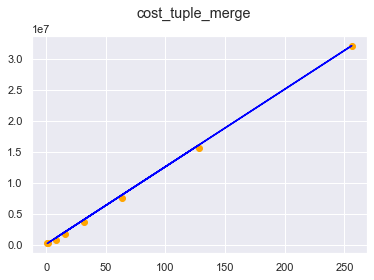

[6678.92280606] 888998.8876258358


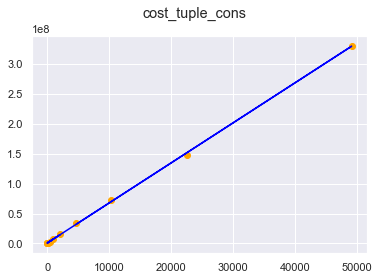

[7008.08883767] 91440.06251369962


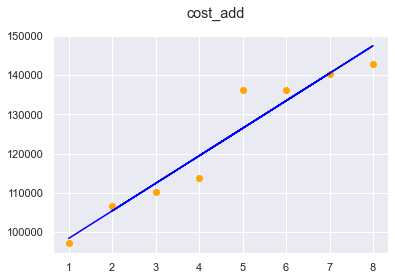

[6828.58520992] 91619.78613856195


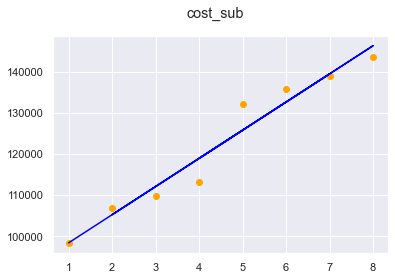

[7740.05227182] 90879.68290785045


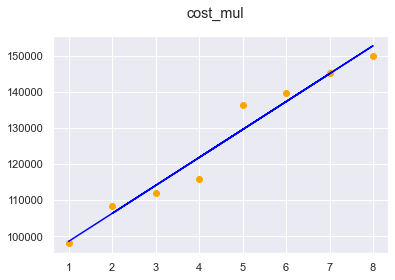

[7991.12468815] 90645.70654386544


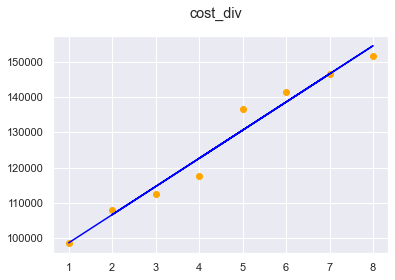

[0.] 97428.96341085271


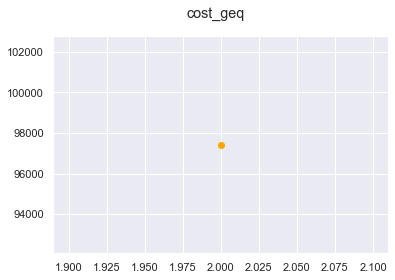

[0.] 98700.89783317801


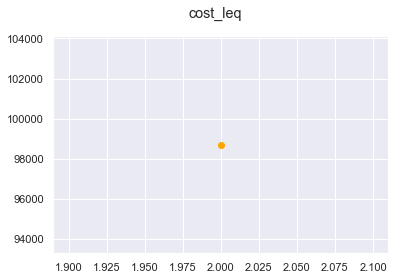

[0.] 91466.76869965477


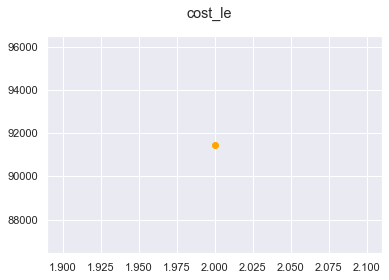

[0.] 91731.39526092568


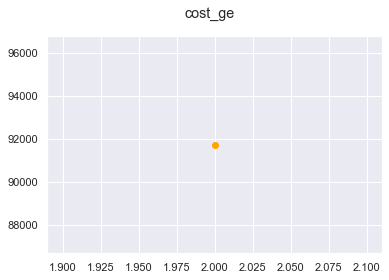

[0.] 94748.98324806507


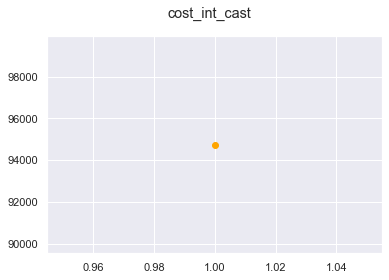

[0.] 100032.70519114687


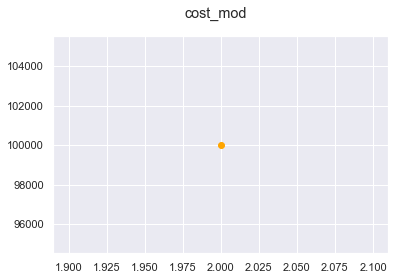

[0.] 99926.21717299578


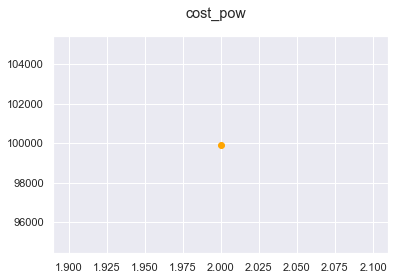

[0.] 99060.61445977012


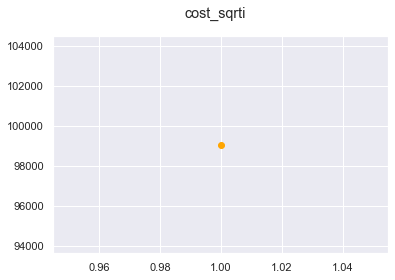

[0.] 93669.27635308307


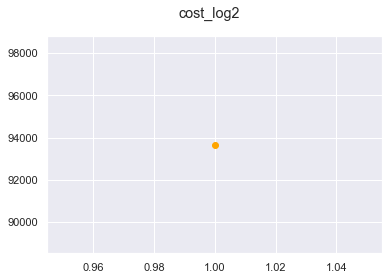

[0.] 98354.07310344827


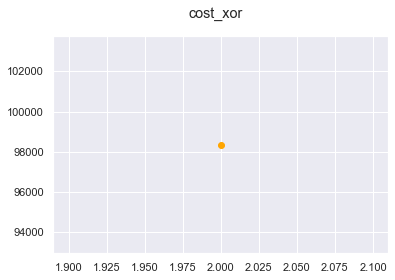

[0.] 95342.05276342975


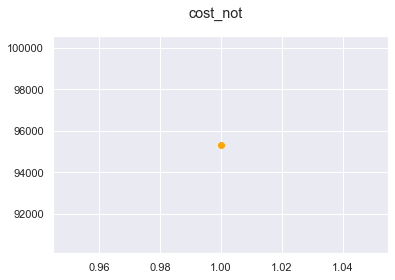

[4872.25928207] 93406.65965941147


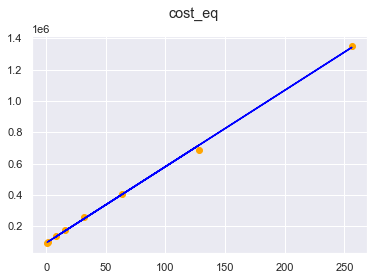

[0.] 113844.0517075517


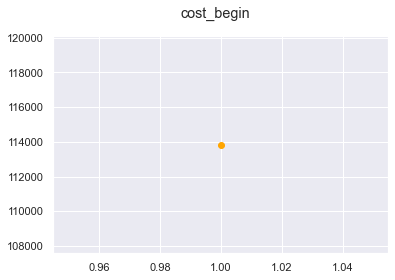

[0.] 167232.99550653592


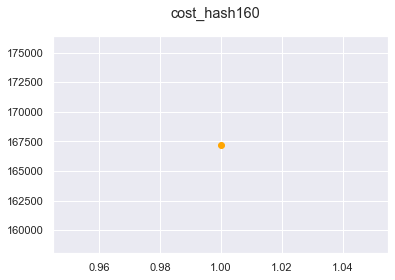

[0.] 142792.13483085542


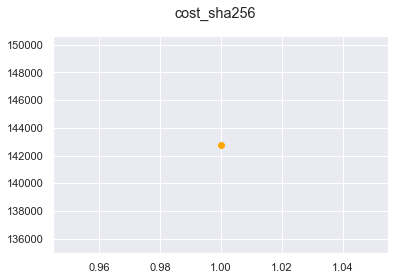

[0.] 142245.98995215312


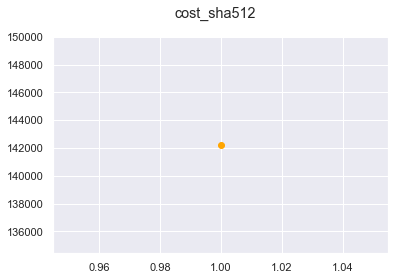

[0.] 145660.57317682318


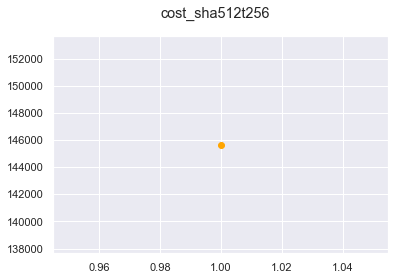

[0.] 155494.62624584718


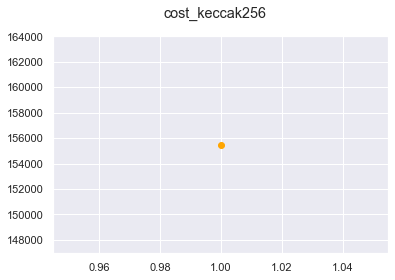

[0.] 8587298.916666668


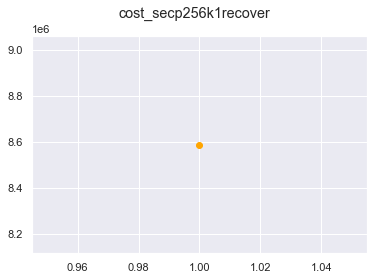

[0.] 8093139.071428571


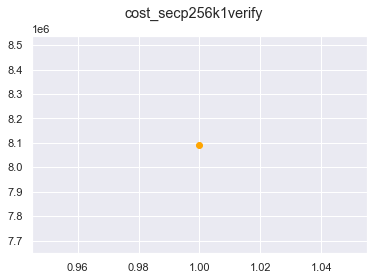

[0.] 930851.733528428


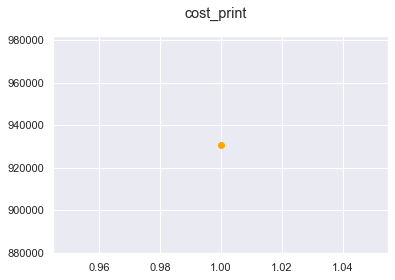

[0.] 130665.63071784421


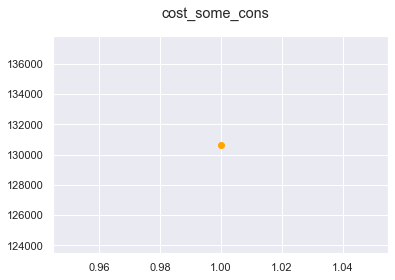

[0.] 125543.23111979166


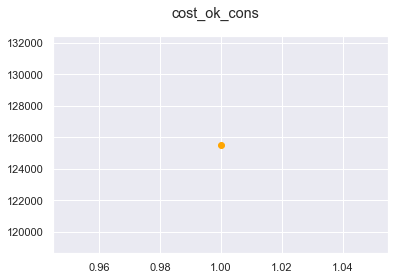

[0.] 123366.38181818182


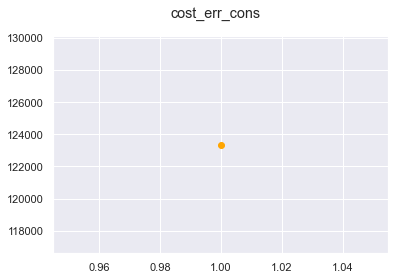

[0.] 153447.5018387225


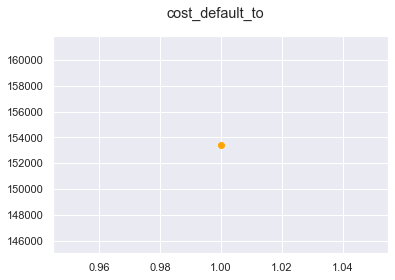

[0.] 198481.62030075188


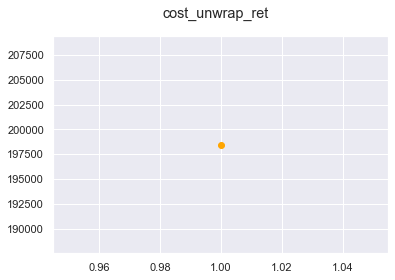

[0.] 191895.9319381599


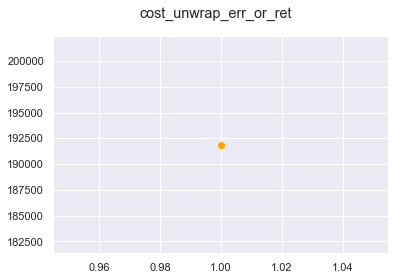

[0.] 165011.60244708994


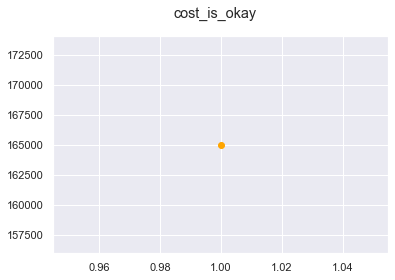

[0.] 137628.92666754202


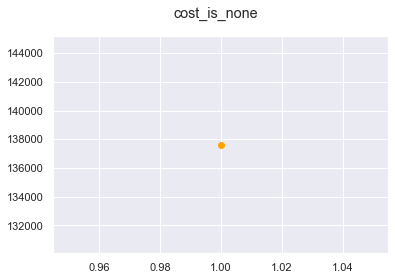

[0.] 161363.48873239435


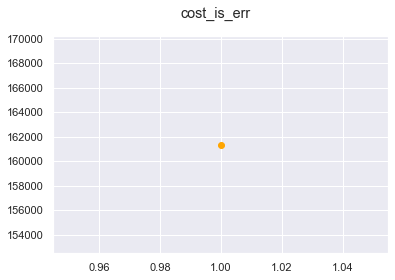

[0.] 130234.13145161289


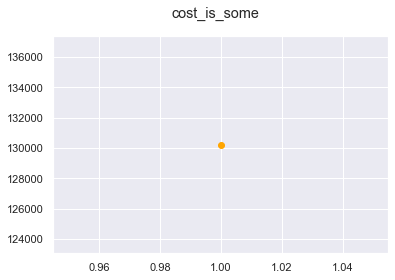

[0.] 168959.69318181818


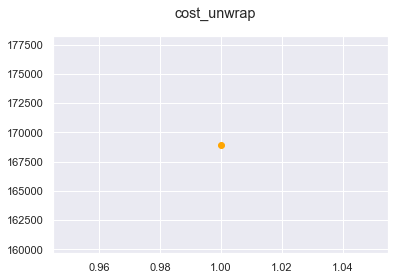

[0.] 164039.17939814815


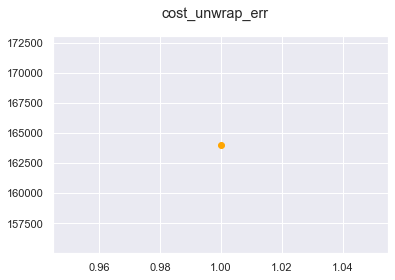

[0.] 165580.89888888889


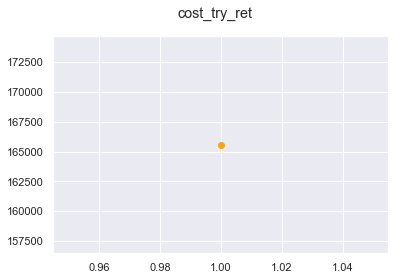

[0.] 189616.61392857143


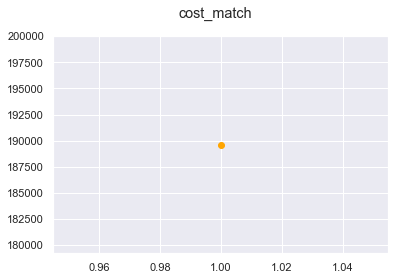

[2077.66119211] 88740.02371925209


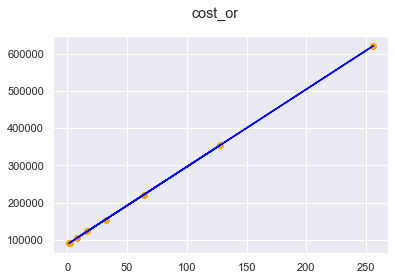

[2080.54020482] 88077.23975358874


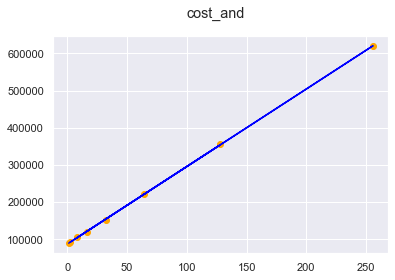

[0.] 614853.980263158


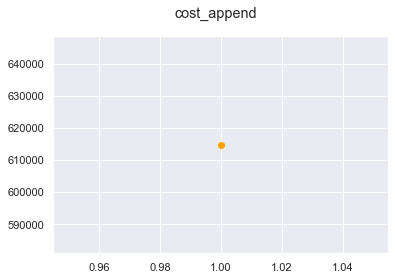

[0.] 602995.0865384615


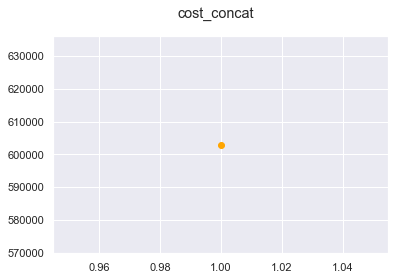

[0.] 289389.7028582317


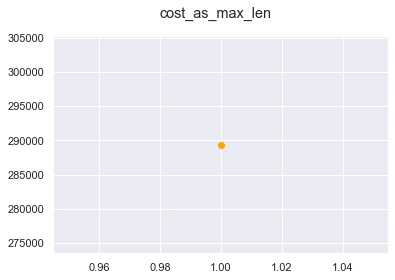

[0.] 92543.01273765156


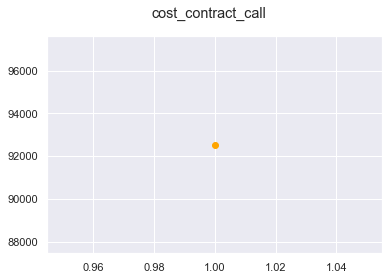

[0.] 8035149.75


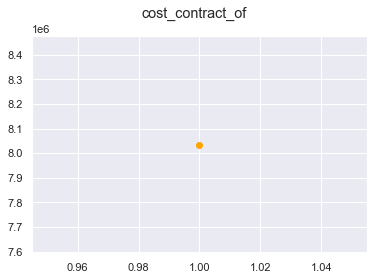

[0.] 9459.416308243728


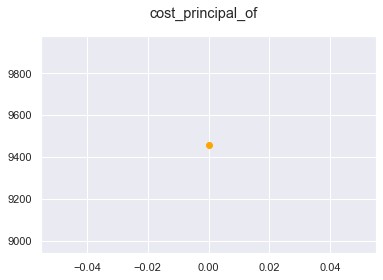

[0.] 123304.05743464053


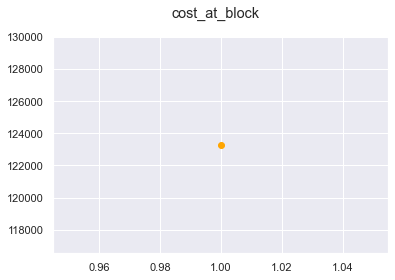

[132.40451749] [6148.89297518]


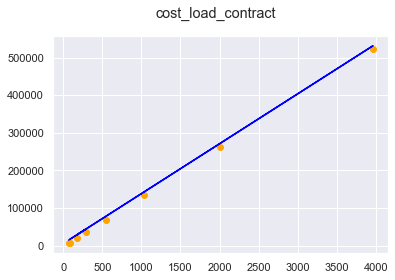

[2182.58749488] 990549.5168913393


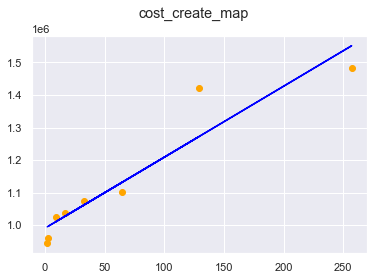

[14655.65176548] 1302435.4910928505


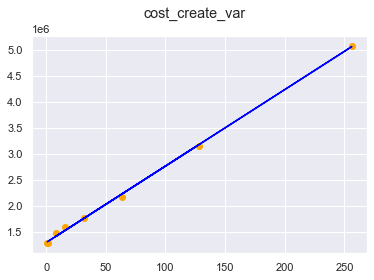

[2760.29362885] 974594.1408540069


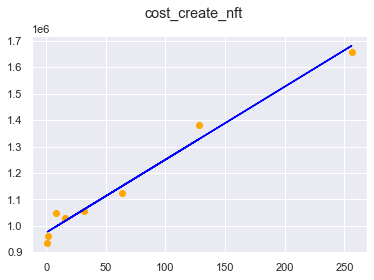

[0.] 1215302.4009866102


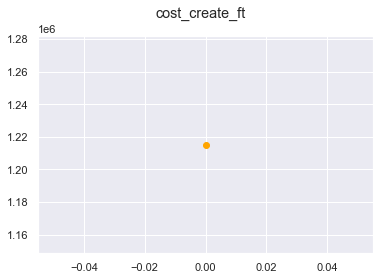

[0.] 879994.2321428572


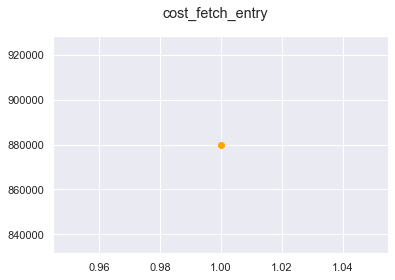

[0.] 944665.3671153847


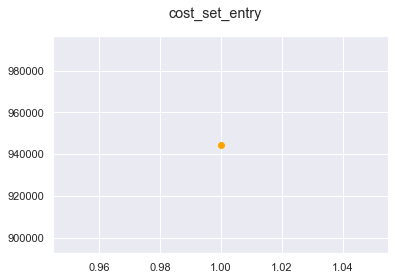

[0.] 407643.1441798942


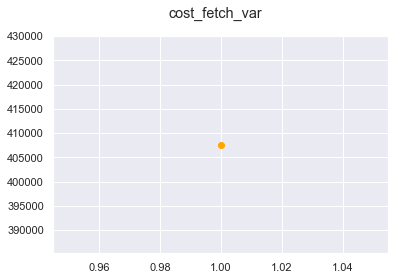

[0.] 433802.93095681886


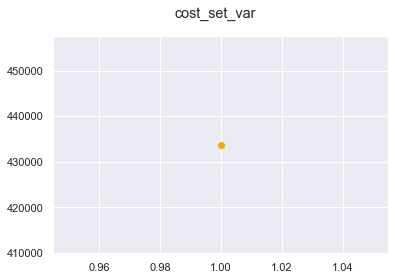

[8384.87146071] 4825918.5761331655


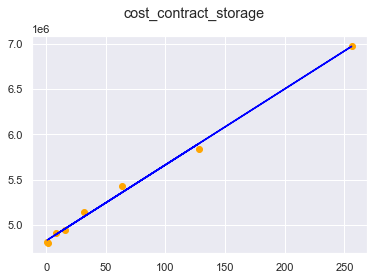

[0.] 3532191.4642857146


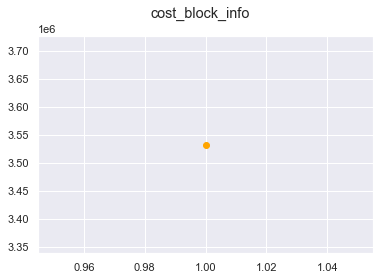

[0.] 832029.0416666667


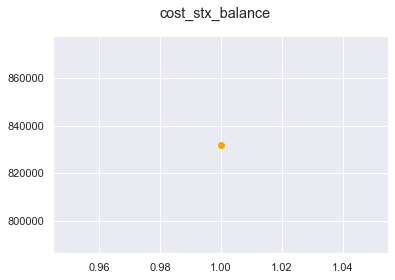

[0.] 866616.957960644


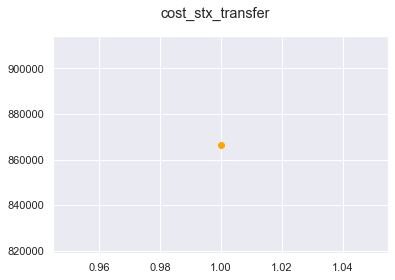

[0.] 974493.9831460675


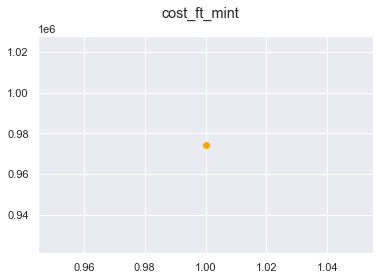

[0.] 337811.8035714286


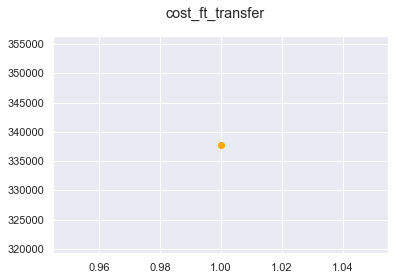

[0.] 326372.32642543863


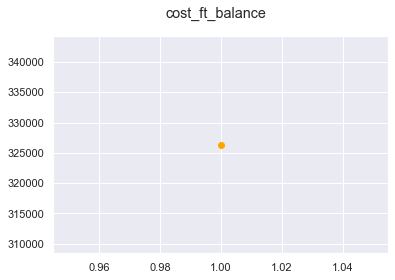

[0.] 434405.71062271064


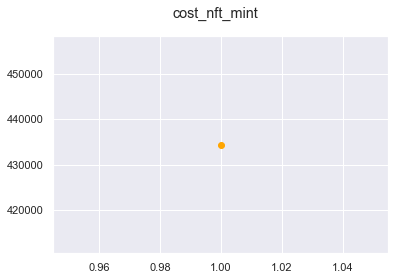

[0.] 472582.1436943272


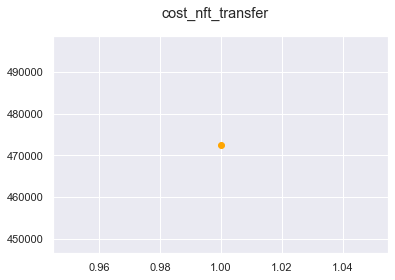

[0.] 408507.23076923075


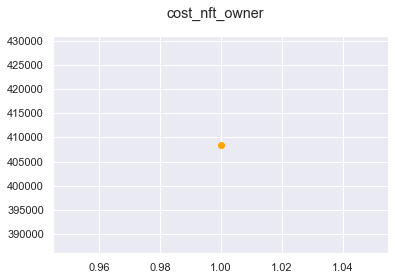

[0.] 284945.4408936652


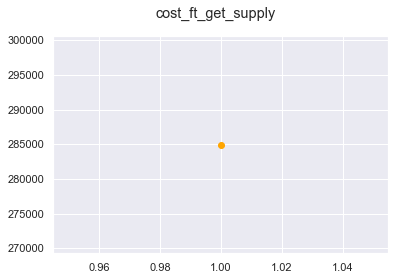

[0.] 359478.6730692277


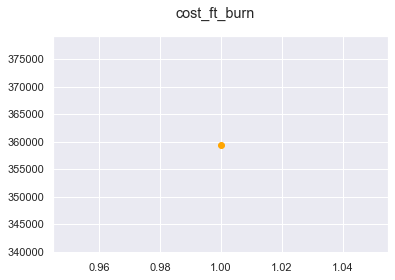

[0.] 386610.70558213716


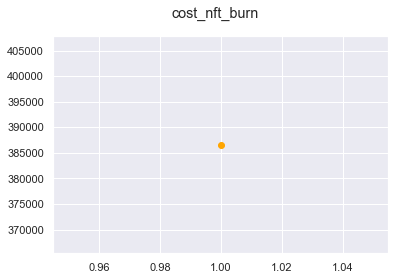

[0.] 17624793.0


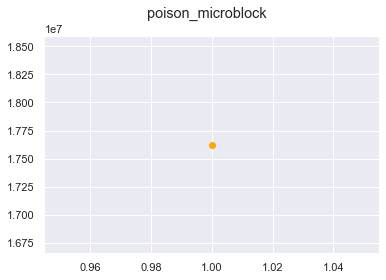

,a,b
cost_analysis_type_annotate,2196.4074118498716,7239.343508
cost_analysis_type_check,67348.89498074794,0.0
cost_analysis_type_lookup,919.7479102770549,3593.992004
cost_analysis_visit,0.0,10220.837827
cost_analysis_iterable_func,158002.6869233415,0.0
cost_analysis_option_cons,0.0,30660.137142
cost_analysis_option_check,0.0,78639.885027
cost_analysis_bind_name,8924.607712266257,86854.444431
cost_analysis_list_items_check,15329.073034671783,3096.956173790153
cost_analysis_check_tuple_get,18.190943810253646,1181.457662


In [4]:
output = pd.DataFrame(columns=["a", "b"])

estimate_plot(df, 'cost_analysis_type_annotate', output)
estimate_plot(df, 'cost_analysis_type_check', output)
estimate_plot(df, 'cost_analysis_type_lookup', output)
estimate_plot(df, 'cost_analysis_visit', output)
estimate_plot(df, 'cost_analysis_iterable_func', output)
estimate_plot(df, 'cost_analysis_option_cons', output)
estimate_plot(df, 'cost_analysis_option_check', output)
estimate_plot(df, 'cost_analysis_bind_name', output)
estimate_plot(df, 'cost_analysis_list_items_check', output)
estimate_plot(df, 'cost_analysis_check_tuple_get', output, nlogn)
# estimate_plot(df, 'cost_analysis_check_tuple_merge ', output)
estimate_plot(df, 'cost_analysis_check_tuple_cons', output, nlogn)
estimate_plot(df, 'cost_analysis_tuple_items_check', output)
estimate_plot(df, 'cost_analysis_check_let', output)
estimate_plot(df, 'cost_analysis_lookup_function', output)
estimate_plot(df, 'cost_analysis_lookup_function_types', output)
estimate_plot(df, 'cost_analysis_lookup_variable_const', output)
estimate_plot(df, 'cost_analysis_lookup_variable_depth', output, nlogn)
estimate_plot(df, 'cost_arithmetic_only_checker', output)
estimate_plot(df, 'cost_read_only', output)
estimate_plot(df, 'cost_trait_checker', output)
estimate_plot(df, 'cost_type_checker', output)
estimate_plot(df, 'cost_ast_parse', output)
estimate_plot(df, 'cost_ast_cycle_detection', output)
estimate_plot(df, 'cost_analysis_storage', output)
estimate_plot(df, 'cost_analysis_use_trait_entry', output)
estimate_plot(df, 'cost_analysis_get_function_entry', output)
# do we have a benchmark for this?
# estimate_plot(df, 'cost_analysis_fetch_contract_entry', output)
estimate_plot(df, 'cost_lookup_variable_depth', output)
estimate_plot(df, 'cost_lookup_variable_size', output)
estimate_plot(df, 'cost_lookup_function', output)
estimate_plot(df, 'cost_bind_name', output)
estimate_plot(df, 'cost_inner_type_check_cost', output)
estimate_plot(df, 'cost_user_function_application', output)
estimate_plot(df, 'cost_let', output)
estimate_plot(df, 'cost_if', output)
estimate_plot(df, 'cost_asserts', output)
estimate_plot(df, 'cost_map', output)
estimate_plot(df, 'cost_filter', output)
estimate_plot(df, 'cost_len', output)
estimate_plot(df, 'cost_element_at', output)
estimate_plot(df, 'cost_index_of', output)
estimate_plot(df, 'cost_fold', output)
estimate_plot(df, 'cost_list_cons', output)
estimate_plot(df, 'cost_type_parse_step', output)
estimate_plot(df, 'cost_tuple_get', output, nlogn)
estimate_plot(df, 'cost_tuple_merge', output)
estimate_plot(df, 'cost_tuple_cons', output, nlogn)
estimate_plot(df, 'cost_add', output)
estimate_plot(df, 'cost_sub', output)
estimate_plot(df, 'cost_mul', output)
estimate_plot(df, 'cost_div', output)
estimate_plot(df, 'cost_geq', output)
estimate_plot(df, 'cost_leq', output)
estimate_plot(df, 'cost_le', output)
estimate_plot(df, 'cost_ge', output)
estimate_plot(df, 'cost_int_cast', output)
estimate_plot(df, 'cost_mod', output)
estimate_plot(df, 'cost_pow', output)
estimate_plot(df, 'cost_sqrti', output)
estimate_plot(df, 'cost_log2', output)
estimate_plot(df, 'cost_xor', output)
estimate_plot(df, 'cost_not', output)
estimate_plot(df, 'cost_eq', output)
estimate_plot(df, 'cost_begin', output)
estimate_plot(df, 'cost_hash160', output)
estimate_plot(df, 'cost_sha256', output)
estimate_plot(df, 'cost_sha512', output)
estimate_plot(df, 'cost_sha512t256', output)
estimate_plot(df, 'cost_keccak256', output)
estimate_plot(df, 'cost_secp256k1recover', output)
estimate_plot(df, 'cost_secp256k1verify', output)
estimate_plot(df, 'cost_print', output)
estimate_plot(df, 'cost_some_cons', output)
estimate_plot(df, 'cost_ok_cons', output)
estimate_plot(df, 'cost_err_cons', output)
estimate_plot(df, 'cost_default_to', output)
estimate_plot(df, 'cost_unwrap_ret', output)
estimate_plot(df, 'cost_unwrap_err_or_ret', output)
estimate_plot(df, 'cost_is_okay', output)
estimate_plot(df, 'cost_is_none', output)
estimate_plot(df, 'cost_is_err', output)
estimate_plot(df, 'cost_is_some', output)
estimate_plot(df, 'cost_unwrap', output)
estimate_plot(df, 'cost_unwrap_err', output)
estimate_plot(df, 'cost_try_ret', output)
estimate_plot(df, 'cost_match', output)
estimate_plot(df, 'cost_or', output)
estimate_plot(df, 'cost_and', output)
estimate_plot(df, 'cost_append', output)
estimate_plot(df, 'cost_concat', output)
estimate_plot(df, 'cost_as_max_len', output)
estimate_plot(df, 'cost_contract_call', output)
estimate_plot(df, 'cost_contract_of', output)
estimate_plot(df, 'cost_principal_of', output)
estimate_plot(df, 'cost_at_block', output)
estimate_plot(df, 'cost_load_contract', output)
estimate_plot(df, 'cost_create_map', output)
estimate_plot(df, 'cost_create_var', output)
estimate_plot(df, 'cost_create_nft', output)
estimate_plot(df, 'cost_create_ft', output)
estimate_plot(df, 'cost_fetch_entry', output)
estimate_plot(df, 'cost_set_entry', output)
estimate_plot(df, 'cost_fetch_var', output)
estimate_plot(df, 'cost_set_var', output)
estimate_plot(df, 'cost_contract_storage', output)
estimate_plot(df, 'cost_block_info', output)
estimate_plot(df, 'cost_stx_balance', output)
estimate_plot(df, 'cost_stx_transfer', output)
estimate_plot(df, 'cost_ft_mint', output)
estimate_plot(df, 'cost_ft_transfer', output)
estimate_plot(df, 'cost_ft_balance', output)
estimate_plot(df, 'cost_nft_mint', output)
estimate_plot(df, 'cost_nft_transfer', output)
estimate_plot(df, 'cost_nft_owner', output)
estimate_plot(df, 'cost_ft_get_supply', output)
estimate_plot(df, 'cost_ft_burn', output)
estimate_plot(df, 'cost_nft_burn', output)
estimate_plot(df, 'poison_microblock', output)

output

In [5]:
output.to_csv("cost_constants.csv")